In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import random
import sys
from typing import List, Union

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from wisard.encoders import ThermometerEncoder, encode_dataset
from wisard.wisard import WiSARD, model_from_coded_mental_image
from wisard.utils import untie, get_random_permutation, permute_dataset_bits
from wisard.optimize import find_best_bleach_bayesian, find_best_bleach_bin_search

from wisard.data import IrisDataset
from keras.datasets import mnist, fashion_mnist


%matplotlib inline

2022-09-05 12:32:24.865885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 12:32:24.865928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def sample_digit(target: int, X, y):
    return next((digit for (digit, label) in zip(X, y)
                 if int(label) == int(target))).reshape((28, 28))


def display_mnist_digits(X,
                         y,
                         figsize=(16, 8),
                         vmin: float = None,
                         vmax: float = None,
                         cmap: str = "gray"):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for i in range(2):
        for j in range(5):
            im = axs[i, j].imshow(
                sample_digit(target=5 * i + j, X=X, y=y),
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
            )
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
            if vmin is None or vmax is None:
                fig.colorbar(im, ax=axs[i, j], shrink=0.6)
    if vmin is not None and vmax is not None:
        fig.colorbar(im, ax=axs[:, 4], location="right", shrink=0.6)
    plt.show()


def do_train_and_evaluate(x_train,
                          y_train,
                          x_test,
                          y_test,
                          tuple_size: int,
                          input_indexes: List[int] = None,
                          shuffle_indexes: bool = True,
                          bleach: Union[int, str] = "auto",
                          **kwargs):
    num_classes = len(np.unique(y_train))

    print(" ----- Training model ----- ")            

    if input_indexes is None:
        input_indexes = np.arange(x_train[0].size)
    if shuffle_indexes:
        np.random.shuffle(input_indexes)
    print(f"Using input_indexes: {input_indexes}")

    model = WiSARD(num_inputs=x_train[0].size,
                   num_classes=num_classes,
                   unit_inputs=tuple_size,
                   unit_entries=1,
                   unit_hashes=1,
                   input_idxs=input_indexes,
                   shared_rand_vals=False,
                   randomize=False,
                   use_dict=True)

    model.fit(x_train, y_train)
    max_bleach = model.max_bleach()
    print(f"Max bleach is: {max_bleach}\n")

    print(" ----- Evaluating model ----- ")

    if isinstance(bleach, int):
        y_pred = model.predict(x_test, y_test, bleach=bleach, use_tqdm=True)
        y_pred, ties = untie(y_pred, use_tqdm=False)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}")
    elif bleach == "auto":
        bleach = find_best_bleach_bin_search(model,
                                           X=x_test,
                                           y=y_test,
                                           min_bleach=1,
                                           max_bleach=max_bleach//4,
                                           **kwargs)
    else:
        raise ValueError(f"Invalid value for bleach: '{bleach}'")

    return model, bleach

In [3]:
shared_rand_vals = True  # not used...
input_size = 24
num_classes = 10
tuple_size = 24
unit_entries = 1  # Only used for BloomFilter
unit_hashes = 1  # Only used for BloomFilter
input_idxs = np.random.shuffle(np.arange(input_size))  # Order to select elements
# input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()
randomize = False  # Randomize selection order?

## Randomized inputs

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 92476.81it/s]


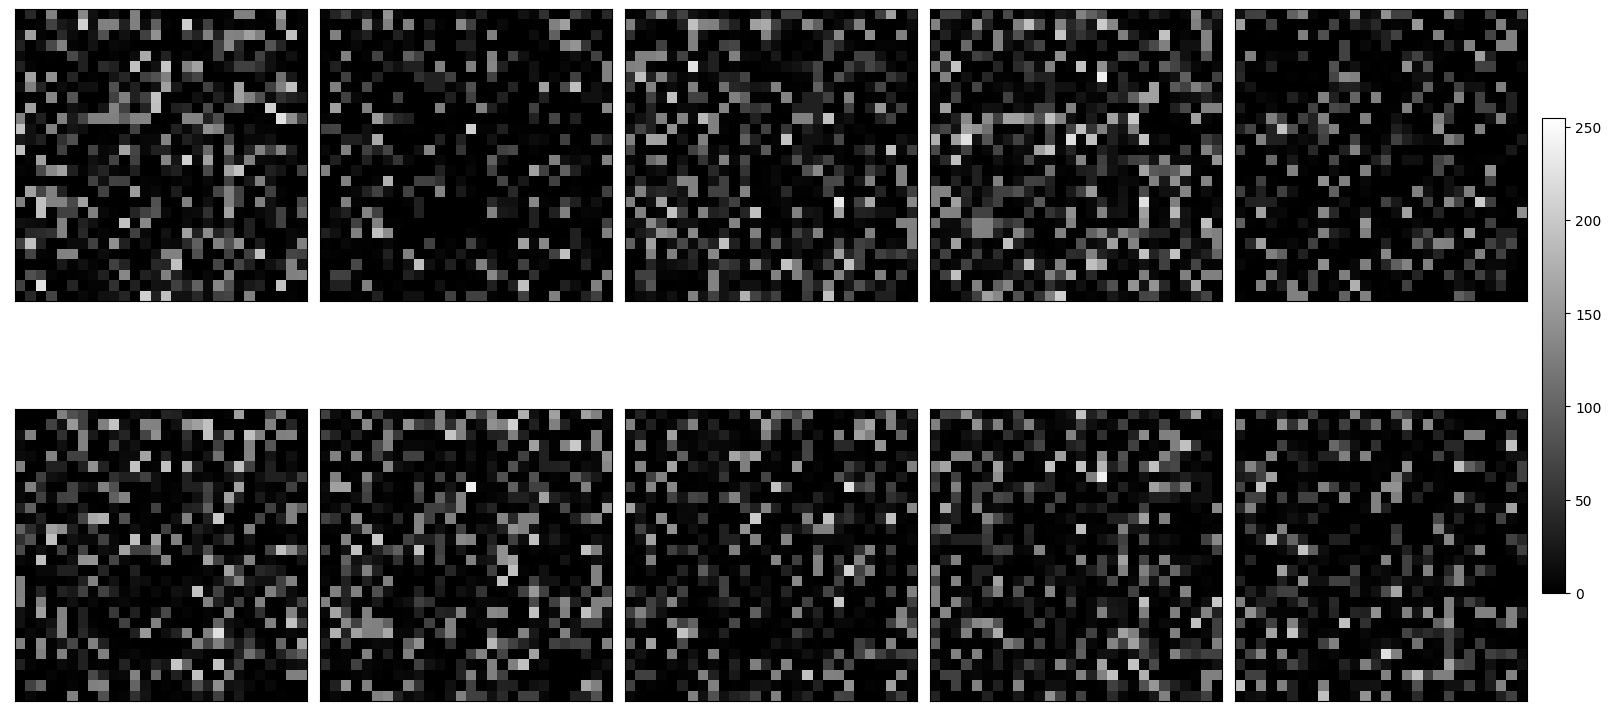

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
permutation = np.arange(np.unpackbits(x_train[0]).size)
permutation = np.random.permutation(permutation)
permutation

x_train = permute_dataset_bits(x_train, permutation)
x_test  = permute_dataset_bits(x_test, permutation)

display_mnist_digits(x_train, y_train, vmin=0, vmax=255)

In [7]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=24)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10399.23it/s]


In [9]:
input_size = x_train[0].size

model, bleach = do_train_and_evaluate(x_train[:1000],
                                      y_train[:1000],
                                      x_test[:10],
                                      y_test[:10],
                                      input_indexes=None,
                                      tuple_size=24,
                                      bleach="auto",
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [    0     1     2 ... 18813 18814 18815]
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT


Training model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.38it/s]


Max bleach is: 117

 ----- Evaluating model ----- 
Testing with bleach=7
[b=7] Accuracy=0.500, ties=0
Testing with bleach=14
[b=14] Accuracy=0.600, ties=1
Testing with bleach=21
[b=21] Accuracy=0.400, ties=1
Testing with bleach=11
[b=11] Accuracy=0.700, ties=0
Testing with bleach=14
[b=14] Accuracy=0.600
Testing with bleach=17
[b=17] Accuracy=0.500, ties=0
Testing with bleach=10
[b=10] Accuracy=0.700, ties=0
Testing with bleach=11
[b=11] Accuracy=0.700
Testing with bleach=12
[b=12] Accuracy=0.700, ties=0
Testing with bleach=9
[b=9] Accuracy=0.700, ties=0
Testing with bleach=10
[b=10] Accuracy=0.700
Testing with bleach=11
[b=11] Accuracy=0.700
Testing with bleach=8
[b=8] Accuracy=0.600, ties=1
Testing with bleach=9
[b=9] Accuracy=0.700
Testing with bleach=10
[b=10] Accuracy=0.700
Best bleach: 9....
Best bleach: 9


## Normal MNIST

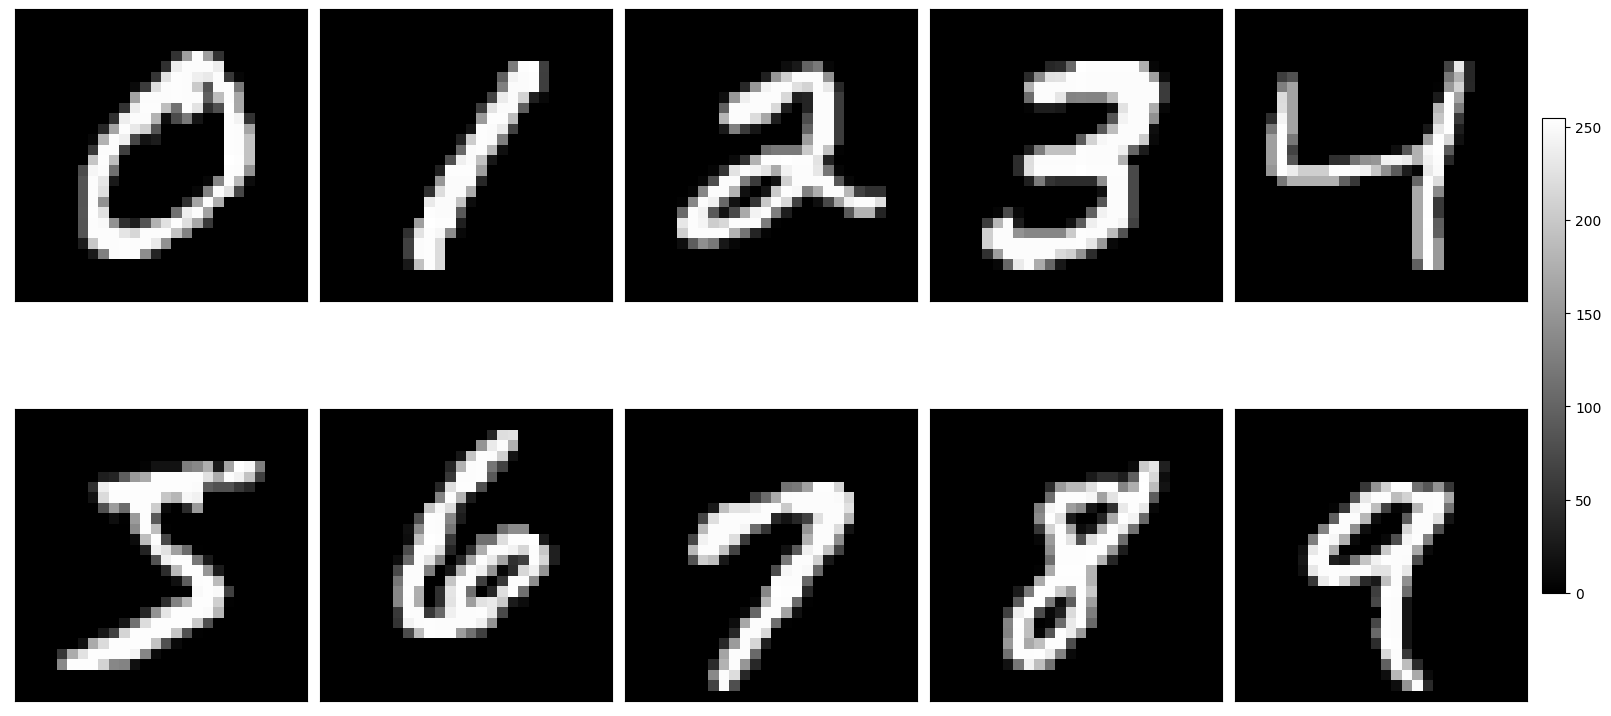

Encoding dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5804.96it/s]


In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
display_mnist_digits(x_train, y_train, vmin=0, vmax=255)

thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=24)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

In [11]:
input_size = x_train[0].size

model, bleach = do_train_and_evaluate(x_train[:1000],
                                      y_train[:1000],
                                      x_test[:10],
                                      y_test[:10],
                                      input_indexes=None,
                                      tuple_size=24,
                                      bleach="auto",
                                      shuffle_indexes=False)
print(f"Best bleach: {bleach}")

 ----- Training model ----- 
Using input_indexes: [    0     1     2 ... 18813 18814 18815]
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT
Instantiating DICT LUT


Training model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.76it/s]


Max bleach is: 117

 ----- Evaluating model ----- 
Testing with bleach=7
[b=7] Accuracy=0.400, ties=0
Testing with bleach=14
[b=14] Accuracy=0.400, ties=0
Testing with bleach=21
[b=21] Accuracy=0.300, ties=2
Testing with bleach=4
[b=4] Accuracy=0.700, ties=1
Testing with bleach=7
[b=7] Accuracy=0.400
Testing with bleach=10
[b=10] Accuracy=0.300, ties=2
Testing with bleach=3
[b=3] Accuracy=0.800, ties=0
Testing with bleach=4
[b=4] Accuracy=0.700
Testing with bleach=5
[b=5] Accuracy=0.700, ties=1
Testing with bleach=2
[b=2] Accuracy=0.700, ties=0
Testing with bleach=3
[b=3] Accuracy=0.800
Testing with bleach=4
[b=4] Accuracy=0.700
Best bleach: 3....
Best bleach: 3
